[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/edit-state-human-feedback.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239520-lesson-3-editing-state-and-human-feedback)

# 그래프 상태 편집

## 복습

우리는 Human-in-the-Loop의 동기에 대해 논의했습니다:

(1) `승인` - 에이전트를 중단하고, 사용자에게 상태를 표시하며, 사용자가 작업을 승인할 수 있도록 할 수 있습니다

(2) `디버깅` - 그래프를 되감아 문제를 재현하거나 회피할 수 있습니다

(3) `편집` - 상태를 수정할 수 있습니다

중단점이 사용자 승인을 어떻게 지원하는지 보여주었지만, 그래프가 중단되었을 때 그래프 상태를 수정하는 방법은 아직 알아보지 않았습니다!

## 목표

이제 그래프 상태를 직접 편집하고 사람의 피드백을 삽입하는 방법을 보여드리겠습니다.

In [23]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [24]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [25]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## 상태 편집

이전에 중단점을 소개했습니다.

중단점을 사용하여 그래프를 중단하고 다음 노드를 실행하기 전에 사용자 승인을 기다렸습니다.

하지만 중단점은 [그래프 상태를 수정할 수 있는 기회](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/)이기도 합니다.

`assistant` 노드 전에 중단점이 있는 에이전트를 설정해보겠습니다.

In [ ]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

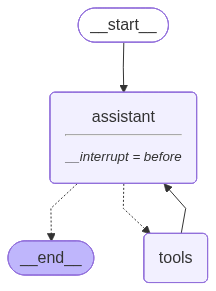

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="당신은 입력값에 대해 산술 연산을 수행하는 임무를 맡은 유용한 보조자입니다."
)


# Node
def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": [response]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

실행해봅시다!

챗 모델이 응답하기 전에 그래프가 중단된 것을 볼 수 있습니다.

In [ ]:
# Input
initial_input = {"messages": "2와 3을 곱하세요"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# 첫 번째 중단이 발생할 때까지 그래프를 실행하십시오
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2와 3을 곱하세요


In [29]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='5d929da1-add6-454c-8573-87d3e254fcbe')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e7da-39b4-6568-8000-bdd9c9cc0472'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-01T04:18:10.144799+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09e7da-39b3-6032-bfff-d1b6b9d0edca'}}, tasks=(PregelTask(id='677cecc9-9809-0833-99ec-ac2cda6d4eff', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

이제 상태 업데이트를 직접 적용할 수 있습니다.

기억하세요, `messages` 키에 대한 업데이트는 `add_messages` 리듀서를 사용합니다:
 
* 기존 메시지를 덮어쓰려면 메시지 `id`를 제공할 수 있습니다.
* 단순히 메시지 목록에 추가하려면 아래와 같이 `id`를 지정하지 않고 메시지를 전달할 수 있습니다.

In [30]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="아니, 사실 3과 3을 곱해 봐!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09e7da-39cb-692a-8001-389b3f40550f'}}

확인해봅시다.

새로운 메시지와 함께 `update_state`를 호출했습니다.

`add_messages` 리듀서가 이를 우리의 상태 키인 `messages`에 추가합니다.

In [31]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

2와 3을 곱하세요
================================ Human Message =================================

아니, 사실 3과 3을 곱해 봐!


이제 단순히 `None`을 전달하고 현재 상태부터 진행하도록 하여 에이전트를 계속 진행해봅시다.

현재 상태를 출력한 다음 남은 노드들을 실행합니다.

In [32]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

아니, 사실 3과 3을 곱해 봐!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_E5DVuKkpUvvWHlU1aRn3yrBs)
 Call ID: call_E5DVuKkpUvvWHlU1aRn3yrBs
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


이제 `breakpoint`가 있는 `assistant`로 돌아왔습니다.

다시 `None`을 전달하여 진행할 수 있습니다.

In [33]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

3과 3을 곱하면 9입니다.


### Studio에서 그래프 상태 편집

로컬 개발 서버를 시작하려면 이 모듈의 `/studio` 디렉토리에서 터미널에 다음 명령어를 실행하세요:

```sh
langgraph dev
```

다음과 같은 출력을 볼 수 있습니다:

```sh
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

브라우저를 열고 Studio UI로 이동하세요: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

LangGraph API는 [그래프 상태 편집을 지원합니다](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).

In [ ]:
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

우리의 에이전트는 `studio/agent.py`에 정의되어 있습니다.

코드를 보면 중단점이 *없는* 것을 알 수 있습니다!
 
물론 `agent.py`에 추가할 수 있지만, API의 매우 유용한 기능 중 하나는 중단점을 전달할 수 있다는 것입니다!

여기서는 `interrupt_before=["assistant"]`를 전달합니다.

In [45]:
initial_input = {"messages": "2와 3을 곱하세요"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '2와 3을 곱하세요', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '35e1f8ae-cb14-4cd8-8461-2b52512070b6', 'example': False}
--------------------------------------------------


현재 상태를 확인할 수 있습니다

In [46]:
current_state = await client.threads.get_state(thread["thread_id"])
current_state

{'values': {'messages': [{'content': '2와 3을 곱하세요',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '35e1f8ae-cb14-4cd8-8461-2b52512070b6',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '18097497-3ca8-283c-7cf9-1d5cddc135d9',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '742e8bb4-922f-4246-a2b4-1014021c89db',
  'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.6.8',
  'langgraph_api_version': '0.4.31',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '01999dfe

상태의 마지막 메시지를 확인할 수 있습니다.

In [47]:
last_message = current_state["values"]["messages"][-1]
last_message

{'content': '2와 3을 곱하세요',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '35e1f8ae-cb14-4cd8-8461-2b52512070b6',
 'example': False}

메시지를 편집할 수 있습니다!

In [48]:
last_message["content"] = "아니, 사실 3과 3을 곱해 봐!"
last_message

{'content': '아니, 사실 3과 3을 곱해 봐!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '35e1f8ae-cb14-4cd8-8461-2b52512070b6',
 'example': False}

In [49]:
last_message

{'content': '아니, 사실 3과 3을 곱해 봐!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '35e1f8ae-cb14-4cd8-8461-2b52512070b6',
 'example': False}

기억하세요, 앞서 말했듯이 `messages` 키에 대한 업데이트는 동일한 `add_messages` 리듀서를 사용합니다.

기존 메시지를 덮어쓰려면 메시지 `id`를 제공할 수 있습니다.

여기서 그렇게 했습니다. 위에서 보이듯이 메시지 `content`만 수정했습니다.

In [50]:
await client.threads.update_state(
    thread["thread_id"],
    {"messages": last_message},
)

{'checkpoint': {'thread_id': '1f5c505b-f858-403e-831c-fc7296cae2a6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09e7de-fbcb-65da-8001-cbb8abb7d841'},
 'configurable': {'thread_id': '1f5c505b-f858-403e-831c-fc7296cae2a6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09e7de-fbcb-65da-8001-cbb8abb7d841'},
 'checkpoint_id': '1f09e7de-fbcb-65da-8001-cbb8abb7d841'}

이제 `None`을 전달하여 재개합니다.

In [51]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"다음 유형의 새 이벤트 수신: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

다음 유형의 새 이벤트 수신: metadata...
--------------------------------------------------
다음 유형의 새 이벤트 수신: values...
{'content': '아니, 사실 3과 3을 곱해 봐!', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '35e1f8ae-cb14-4cd8-8461-2b52512070b6', 'example': False}
--------------------------------------------------
다음 유형의 새 이벤트 수신: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_goNOut6Kb62fx7l2DT2x2kk1', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 144, 'total_tokens': 161, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CLicZqnLl2ZounaymbSdTYyUxrboI', 'serv

예상대로 도구 호출의 결과로 `9`를 얻습니다.

In [54]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"다음 유형의 새 이벤트 수신: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

다음 유형의 새 이벤트 수신: metadata...
--------------------------------------------------
다음 유형의 새 이벤트 수신: values...
{'content': '3과 3을 곱하면 9입니다!', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 13, 'prompt_tokens': 169, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CLict3gOAN5TKhR3bduFlpySVD77j', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--fa793243-3f12-439e-bf44-d9bc3a2513f0-0', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 169, 'output_tokens': 13, 'total_tokens': 182, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, '

## 사용자 입력 대기

따라서 중단점 이후에 에이전트 상태를 편집할 수 있다는 것이 명확합니다.

이제 이 상태 업데이트를 수행하기 위해 사람의 피드백을 허용하려면 어떻게 해야 할까요?

에이전트 내에서 [사람의 피드백을 위한 placeholder 역할을 하는 노드](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup)를 추가하겠습니다.

이 `human_feedback` 노드는 사용자가 상태에 직접 피드백을 추가할 수 있도록 합니다.
 
`human_feedback` 노드 전에 `interrupt_before`를 사용하여 중단점을 지정합니다.

이 노드까지 그래프의 상태를 저장하기 위해 체크포인터를 설정합니다.

In [66]:
# System message
sys_msg = SystemMessage(
    content="당신은 입력값에 대해 산술 연산을 수행하는 임무를 맡은 유용한 보조자입니다."
)


# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass


# Assistant node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
# display(Image(graph.get_graph().draw_mermaid_png()))

사용자로부터 피드백을 받을 것입니다.

이전처럼 `.update_state`를 사용하여 받은 사람의 응답으로 그래프 상태를 업데이트합니다.

`as_node="human_feedback"` 매개변수를 사용하여 이 상태 업데이트를 지정된 노드인 `human_feedback`으로 적용합니다.

In [56]:
# Input
initial_input = {"messages": "2와 3을 곱하세요"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("상태를 어떻게 업데이트하고 싶은지 알려주세요:")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2와 3을 곱하세요
================================ Human Message =================================

3곱하기 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_80xihmMD2ycfwhLaqgVHG5Zu)
 Call ID: call_80xihmMD2ycfwhLaqgVHG5Zu
  Args:
    a: 2
    b: 3
  multiply (call_CthUsT1QR2pMWG2ngLTVrRkJ)
 Call ID: call_CthUsT1QR2pMWG2ngLTVrRkJ
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [57]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

2와 3을 곱한 결과는 6이고, 3 곱하기 3의 결과는 9입니다.


In [62]:
history = graph.get_state_history(thread)
for h in history:
    print(h)

StateSnapshot(values={'messages': [HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='8417703e-93e0-4bdd-8787-61986c5ac75b'), HumanMessage(content='3곱하기 3', additional_kwargs={}, response_metadata={}, id='e688ba2e-061d-41b6-b6c8-55d8d5d68dc4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_80xihmMD2ycfwhLaqgVHG5Zu', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_CthUsT1QR2pMWG2ngLTVrRkJ', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 155, 'total_tokens': 205, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'ch

In [64]:
snapshot = graph.get_state(thread)
snapshot.values["messages"]

[HumanMessage(content='2와 3을 곱하세요', additional_kwargs={}, response_metadata={}, id='8417703e-93e0-4bdd-8787-61986c5ac75b'),
 HumanMessage(content='3곱하기 3', additional_kwargs={}, response_metadata={}, id='e688ba2e-061d-41b6-b6c8-55d8d5d68dc4'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_80xihmMD2ycfwhLaqgVHG5Zu', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_CthUsT1QR2pMWG2ngLTVrRkJ', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 155, 'total_tokens': 205, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CLiee94djjpqvq3Td8utLsNvq